Generation 0 - Maximum spread: 1.00 - Generational distance: 0.12 - HyperVolume: 41.53784236514911 - f1 min: 0.0353 - f2 min: 0.0235
Generation 1 - Maximum spread: 1.00 - Generational distance: 0.10 - HyperVolume: 41.861200268109876 - f1 min: 0.0295 - f2 min: 0.0217
Generation 2 - Maximum spread: 1.00 - Generational distance: 0.05 - HyperVolume: 42.36313687854125 - f1 min: 0.0219 - f2 min: 0.0149
Generation 3 - Maximum spread: 1.00 - Generational distance: 0.02 - HyperVolume: 42.94517939986015 - f1 min: 0.0151 - f2 min: 0.0149
Generation 4 - Maximum spread: 1.00 - Generational distance: 0.02 - HyperVolume: 42.94517939986015 - f1 min: 0.0151 - f2 min: 0.0149
Generation 5 - Maximum spread: 1.00 - Generational distance: 0.01 - HyperVolume: 42.95814958704326 - f1 min: 0.0150 - f2 min: 0.0140
Generation 6 - Maximum spread: 1.00 - Generational distance: 0.01 - HyperVolume: 42.95814958704326 - f1 min: 0.0150 - f2 min: 0.0139
Generation 7 - Maximum spread: 1.00 - Generational distance: 0.01 - 

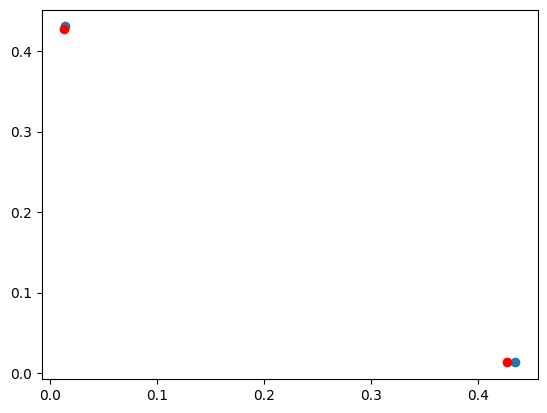

In [6]:
from typing import Tuple, Dict, Union, Optional

import numpy as np

def evaluate_objectives(solutions: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Evaluates and returns both objectives of the problem given a matrix of solutions
    with shape (n_solutions, n_variables). The objectives shape is (n_solutions,)."""

    first_objective = np.exp(-np.prod(solutions - 1 / np.sqrt(3), axis=1))
    second_objective = np.exp(-np.prod(solutions + 1 / np.sqrt(3), axis=1))

    return first_objective, second_objective


def evaluate_constraints(solutions: np.ndarray) -> np.ndarray:
    """Evaluates if the solutions violate the constraint of the problem given a matrix
    of solutions with shape (n_solutions, n_variables) and return a binary array of
    shape (n_solutions,). 1 means that the constraint is satisfied and 0 means that the
    constraint is violated. The constraint is violated if the any the variables of the
    solution is outside the interval [-1.5, 1.5]."""
    return np.prod(np.logical_and(solutions <= 1.5, solutions >= -1.5), axis=1)


def generate_population(n_solutions: int, n_variables: int) -> np.ndarray:
    """Generates a population of solutions with shape (n_solutions, n_variables) using a
    uniform distribution with range [-1.5, 1.5]."""
    return np.random.uniform(low=-1.5, high=1.5, size=(n_solutions, n_variables))


def rank_solutions(
    first_objective: np.ndarray, second_objective: np.ndarray
) -> np.ndarray:
    """Ranks the solutions given the first and second objective of each solution.
    The ranking corresponds to the number of solutions that dominate the solution. The
    smaller the ranking, the better the solution."""

    n_solutions = first_objective.shape[0]

    ranking_list = []

    for first_sol in range(n_solutions):
        # Iterate over every solution
        dominate_count = 0

        for second_sol in range(n_solutions):
            # Compare the solution with every other solution and evaluate if it is
            # dominated
            dominate_first = first_objective[second_sol] < first_objective[first_sol]
            dominate_second = second_objective[second_sol] < second_objective[first_sol]
            if dominate_first and dominate_second:
                # If the solution is dominated, add 1 to the dominate count
                dominate_count += 1

        # Append the dominate count to the ranking list
        ranking_list.append(dominate_count)

    ranking = np.array(ranking_list)

    return ranking


def selections(
    solutions: np.ndarray, ranking: np.ndarray, percentage: float
) -> np.ndarray:
    """Selects the best solutions given the ranking of the solutions. The percentage
    indicates the percentage of solutions to keep. The solutions are selected by
    selecting the best solutions according to the ranking. The ranking is a vector of
    shape (n_solutions,) where the smaller the value, the better the solution. The
    function returns a matrix of shape (n_solutions_to_keep, n_variables)."""

    # Cut the solutions according to a percentage
    n_solutions_to_keep = int(percentage * solutions.shape[0])

    # Sort the solutions by ranking
    best_solution_indices = np.argsort(ranking)[:n_solutions_to_keep]

    return solutions[best_solution_indices]


def cross(solutions: np.ndarray, n_cross: np.ndarray) -> np.ndarray:
    """Crosses the solutions given a matrix of solutions with shape
    (n_solutions, n_variables) and returns a matrix of shape
    (n_solutions + n_cross, n_variables). The cross is performed by swapping the
    variables of two solutions. The number of cross to perform is given by n_cross."""

    # Get the indices of the solutions to mutate
    first_permutation = np.random.permutation(solutions.shape[0])[:n_cross]
    second_permutation = np.random.permutation(solutions.shape[0])[:n_cross]

    solution_array = []
    n_variables = solutions.shape[1]

    for first_sol_ind, second_sol_ind in zip(first_permutation, second_permutation):
        # Iterate over the solutions to mutate

        # Get the solutions to mutate
        first_solution = solutions[first_sol_ind].reshape(1, -1)
        second_solution = solutions[second_sol_ind].reshape(1, -1)

        # Get the variables to mutate
        if n_variables > 2:
            mutation_mask = np.random.choice(
                [True, False], size=solutions.shape[1], p=[0.5, 0.5]
            )
        else:
            random_number = np.random.uniform()
            mutation_mask = np.array([random_number > 0.5, random_number <= 0.5])

        # Swap the variables and append new solution
        new_solution = np.where(mutation_mask, first_solution, second_solution)
        solution_array.append(new_solution)

    # Convert the list to an array
    new_solutions = np.concatenate(solution_array, axis=0)

    # Concatenate the new solutions with the old ones
    new_population = np.concatenate([solutions, new_solutions], axis=0)

    return new_population


def maximum_spread(first_objective: np.ndarray, second_objetive: np.ndarray) -> float:
    acum = 0
    for objective in [first_objective, second_objetive]:
        # Get max and min solution
        maximum_solution = np.max(objective)
        minimum_solution = np.min(objective)

        # Get maz and min non-dominated solution
        maximum_non_dominated_solution = np.max(objective)
        minimum_non_dominated_solution = np.min(objective)

        # Compute the spread and add it to the acum
        acum += (maximum_non_dominated_solution - minimum_non_dominated_solution) / (
            maximum_solution - minimum_solution
        )

    # Take the average and compute square root
    return np.sqrt(acum / 2)


def generational_distance(
    pareto_optimal: np.ndarray,
    non_dom_first_objective: np.ndarray,
    non_dom_second_objective: np.ndarray,
) -> float:
    """Calculate the non generational distance between the pareto optimal solutions and
    the non dominated solutions. The pareto optimal is a matrix of shape
    (n_pareto_solutions, 2)."""

    # Get the non dominated solutions
    non_dominated_solutions = np.concatenate(
        [non_dom_first_objective.reshape(-1, 1), non_dom_second_objective.reshape(-1, 1)], axis=1
    )

    def get_minimum_distance(
        pareto_optimal: np.ndarray, non_dominated_solution: np.ndarray
    ) -> float:
        """Calculates the minimum distance between a given non dominated solution and
        every pareto optimal solution."""

        min_distance = np.inf

        for pareto_solution in range(len(pareto_optimal)):
            difference = pareto_optimal[pareto_solution] - non_dominated_solution
            distance = np.sqrt(np.sum(difference**2))
            if distance < min_distance:
                min_distance = distance

        return min_distance

    # Compute the minimum distance for every non dominated solution
    minimum_distances = []
    for non_dominated_solution in range(len(non_dominated_solutions)):
        minimum_distance = get_minimum_distance(
            pareto_optimal, non_dominated_solutions[non_dominated_solution]
        )
        minimum_distances.append(minimum_distance**2)

    # Compute the average of the minimum distances
    return np.sqrt(np.sum(minimum_distances)) / len(non_dominated_solutions)


def hyper_volume(
    first_objective: np.ndarray, second_objective: np.ndarray, nadir_point: np.ndarray
) -> float:
    """Calculates the hyper volume of the pareto optimal solutions given the first and
    second objective of each solution. The hyper volume is the union of the area
    between the nadir point and the non dominated solutions. The nadir point is a
    vector of shape (2,). The first and second objective are vectors of shape
    (n_solutions,)."""

    # Sort the pareto optimal solutions by the first objective
    sorted_indices = np.argsort(first_objective)
    sorted_first_objective = first_objective[sorted_indices]
    sorted_second_objective = second_objective[sorted_indices]

    # Compute the hyper volume
    acum = 0
    new_nadir_point = nadir_point.copy()
    for i in range(len(sorted_first_objective) - 1):
        acum += (new_nadir_point[0] - sorted_first_objective[i]) * (
            new_nadir_point[1] - sorted_second_objective[i]
        )
        new_nadir_point[1] = sorted_second_objective[i]

    return acum


def evaluate_optimality(
    population: np.ndarray,
    generation_i: int,
    pareto_optimal: np.ndarray = None,
    nadir_point: np.ndarray = None,
    return_mask: bool = False,
    verbose: bool = True,
) -> Optional[np.ndarray]:
    """Evaluates the optimality of the solutions in the population. The optimality is
    evaluated by computing the maximum spread and the hyper volume of the non dominated
    solutions. The non dominated solutions are the solutions that are not dominated by
    any other solution. The function returns the mask of the non dominated solutions if
    return_mask is True. Otherwise, it returns the ranking of the solutions."""

    # Evaluate objectives and constraints
    first_objective, second_objective = evaluate_objectives(population)

    # Compute ranking
    ranking = rank_solutions(first_objective, second_objective)

    # Get of non-dominated solutions and apply mask to objectives
    non_dominated_solutions_mask = np.logical_not(ranking)
    non_dom_first_objective = first_objective[non_dominated_solutions_mask]
    non_dom_second_objective = second_objective[non_dominated_solutions_mask]

    if verbose:
        # Print generation information

        # Compute maximum spread
        maximum_spread_value = maximum_spread(
            non_dom_first_objective, non_dom_second_objective
        )

        print_message = f"Generation {generation_i} - Maximum spread: {maximum_spread_value:.2f}"

        if pareto_optimal is not None:
            # Generate pareto optimal solutions
            generational_distance_value = generational_distance(
                pareto_optimal,
                non_dom_first_objective,
                non_dom_second_objective,
            )

            print_message += f" - Generational distance: {generational_distance_value:.2f}"

        if nadir_point is not None:
            # Compute Hyper volume
            hyper_volume_value = hyper_volume(
                non_dom_first_objective,
                non_dom_second_objective,
                nadir_point,
            )

            print_message += f" - HyperVolume: {hyper_volume_value}"

        print_message += (
            f" - f1 min: {np.min(non_dom_first_objective):.4f}"
            f" - f2 min: {np.min(non_dom_second_objective):.4f}"
        )

        print(print_message)

    if return_mask:
        return non_dominated_solutions_mask

    return ranking


def run_optimization_pipeline(
    initial_population: int,
    n_variables: int,
    percentage: float,
    n_generations: int,
    n_cross: int,
    n_new_solutions: int,
    nadir_point: np.ndarray = None,
    pareto_optimal: np.ndarray = None,
) -> np.ndarray:
    # Generate initial population
    population = generate_population(initial_population, n_variables)

    for generation_i in range(n_generations):
        # Iterate over the generations

        # Evaluate optimality
        ranking = evaluate_optimality(
            population,
            generation_i,
            nadir_point=nadir_point,
            pareto_optimal=pareto_optimal,
        )

        # Selection
        selected_solutions = selections(population, ranking, percentage=percentage)

        # Cross
        new_population = cross(selected_solutions, n_cross=n_cross)

        # Remove repeated solutions
        new_population = np.unique(new_population, axis=0)

        # Generate new solutions
        if len(new_population) + n_new_solutions < initial_population:
            new_population_size = (
                initial_population - len(new_population) - n_new_solutions
            )
        else:
            new_population_size = n_new_solutions
        new_solutions = generate_population(new_population_size, n_variables)

        # Concatenate new solutions with the old ones
        population = np.concatenate([new_population, new_solutions], axis=0)

    # Evaluate optimality
    non_dominated_solutions_mask = evaluate_optimality(
        population,
        generation_i,
        nadir_point=nadir_point,
        pareto_optimal=pareto_optimal,
        return_mask=True,
    )

    # Return non dominated solutions
    return population[non_dominated_solutions_mask]


def make_combinations(n_variables: int) -> np.ndarray:
    """Makes all the possible combinations of the vector [-1.5, 1.5] with n_variables
    using a 100 point discretization."""
    return np.array(
        np.meshgrid(*[np.linspace(-1.5, 1.5, 100)] * n_variables)
    ).T.reshape(-1, n_variables)


def plot_solutions(solutions: np.ndarray, pareto_optimal: np.ndarray = None, nadir_point: np.ndarray = None):
    import matplotlib.pyplot as plt

    plt.scatter(solutions[:, 0], solutions[:, 1])
    if pareto_optimal is not None:
        plt.scatter(pareto_optimal[:, 0], pareto_optimal[:, 1], c="g")
    if nadir_point is not None:
        plt.scatter(nadir_point[0], nadir_point[1], c="r")
    plt.xlabel("Z1")
    plt.ylabel("Z2")
    plt.title("Pareto front")
    plt.show()


def main(args: Dict[str, Union[int, float]]):

    if args["n_variables"] == 2:
        # Generate pareto optimal solutions
        solutions = make_combinations(2)

        # Evaluate objectives and constraints
        first_objective, second_objective = evaluate_objectives(solutions)

        non_dominated_solutions_mask = evaluate_optimality(
            solutions, generation_i=0, return_mask=True, verbose=False
        )

        non_dom_first_objective = first_objective[non_dominated_solutions_mask]
        non_dom_second_objective = second_objective[non_dominated_solutions_mask]

        args["pareto_optimal"] = np.concatenate(
            [non_dom_first_objective.reshape(-1, 1), non_dom_second_objective.reshape(-1, 1)], axis=1
        )

        args["nadir_point"] = np.array([6.79, 6.79])

    else:

        args["nadir_point"] = np.array([1.0, 1.0])
        args["pareto_optimal"] = None

    # Run algorithm
    solutions = run_optimization_pipeline(**args)

    unique_solutions = np.unique(solutions, axis=0)

    first_objective, second_objective = evaluate_objectives(unique_solutions)

    objective_matrix = np.concatenate(
        [first_objective.reshape(-1, 1), second_objective.reshape(-1, 1)], axis=1
    )

    plot_solutions(
        objective_matrix,
        pareto_optimal=args["pareto_optimal"],
        nadir_point=args["nadir_point"]
    )


if __name__ == "__main__":
    # Parse arguments
    args = {
        "initial_population": 300,
        "n_variables": 2,
        "percentage": 0.3,
        "n_generations": 10,
        "n_cross": 50,
        "n_new_solutions": 50
    }

    main(args)
